In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
def count(df,feature):
    total=df.loc[:,feature].value_counts(dropna=False)
    percent=round(df.loc[:,feature].value_counts(dropna=False,normalize=True),2)*100
    return pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    

In [6]:
count(df,'Country').T

,United Kingdom,Germany,France,EIRE,Spain,Netherlands,Belgium,Switzerland,Portugal,Australia,...,Malta,United Arab Emirates,European Community,RSA,Lebanon,Lithuania,Brazil,Czech Republic,Bahrain,Saudi Arabia
Total,495478.0,9495.0,8557.0,8196.0,2533.0,2371.0,2069.0,2002.0,1519.0,1259.0,...,127.0,68.0,61.0,58.0,45.0,35.0,32.0,30.0,19.0,10.0
Percent,91.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


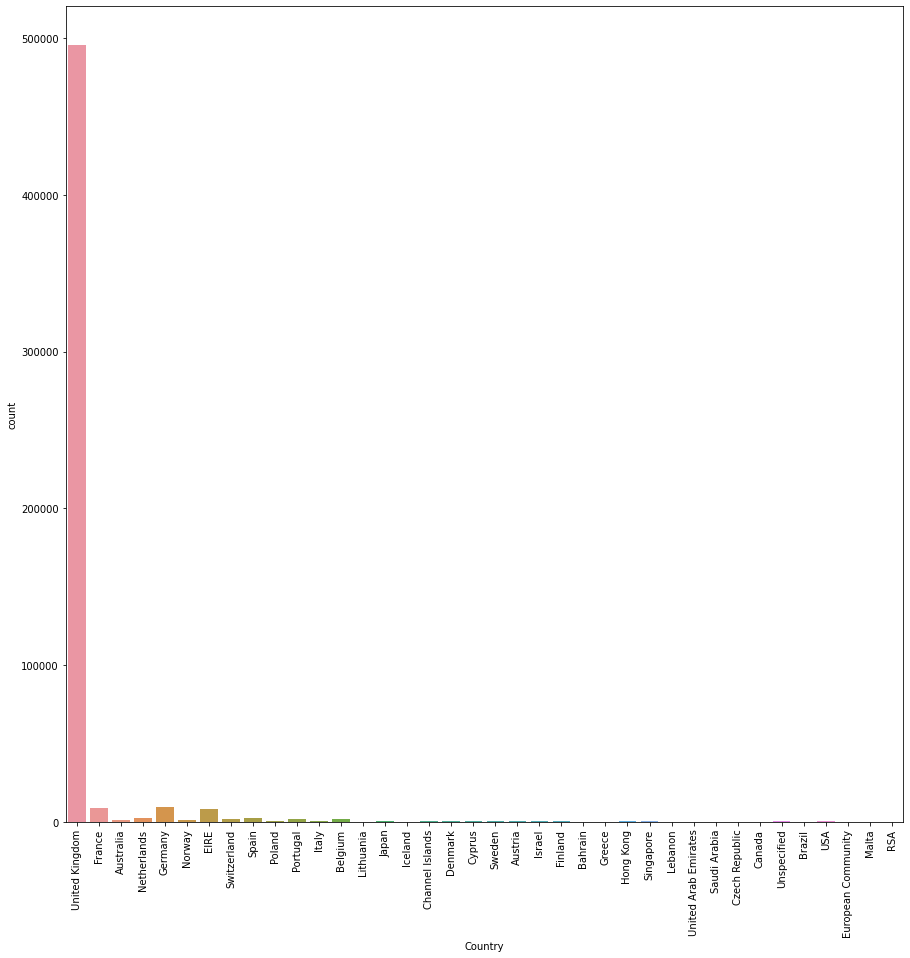

In [7]:
plt.figure(figsize=(15,15))
sns.countplot(x="Country", data=df)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [8]:
df.shape

(541909, 8)

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df.duplicated().sum()

5268

In [11]:
df=df.drop_duplicates().reset_index(drop=True)

In [12]:
df['TotalPrice']=df['UnitPrice']*df['UnitPrice']

In [13]:
df_country=df.groupby('Country').agg({'TotalPrice': lambda x: x.sum()})

In [14]:
df_country.T

Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
TotalPrice,208181.3168,28859.1846,611.6147,64735.7883,884.0402,305388.0148,201419.643,336679.737,1720.4263,10211.7187,...,1828.3406,75.3965,6.328910e+07,4.319920e+06,38706.1801,81259.3039,2912.9138,2689.4263,4.897287e+09,6889.5949


In [15]:
import datetime as dt


In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [17]:
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [18]:
pin_df=max(df['InvoiceDay'])+dt.timedelta(1)
pin_df

Timestamp('2011-12-10 00:00:00')

In [19]:
rfm=df.groupby('CustomerID').agg({'InvoiceDay':lambda x:(pin_df-x.max()).days,'InvoiceNo':'count','TotalPrice':'sum'})

In [20]:
rfm

,InvoiceDay,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,2,2.1632
12347.0,3,182,2193.0251
12348.0,76,31,6417.2943
12349.0,19,73,93356.9820
12350.0,311,17,1645.0300
...,...,...,...
18280.0,278,10,282.0525
18281.0,181,7,584.3592
18282.0,8,13,585.9760


In [21]:
rfm.rename(columns= {
    'InvoiceDay': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,2.1632
12347.0,3,182,2193.0251
12348.0,76,31,6417.2943
12349.0,19,73,93356.9820
12350.0,311,17,1645.0300
...,...,...,...
18280.0,278,10,282.0525
18281.0,181,7,584.3592
18282.0,8,13,585.9760


In [22]:
r_labels=range(4,0,-1)
r_groups=pd.qcut(rfm['Recency'],q=4,labels=r_labels)
f_groups=pd.qcut(rfm['Frequency'],q=4,labels=r_labels)
m_groups=pd.qcut(rfm['Monetary'],q=4,labels=r_labels)


In [23]:
rfm['R']=r_groups.values
rfm['F']=f_groups.values
rfm['M']=m_groups.values


In [24]:
rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,2.1632,1,4,4
12347.0,3,182,2193.0251,4,1,1
12348.0,76,31,6417.2943,2,3,1
12349.0,19,73,93356.9820,3,2,1
12350.0,311,17,1645.0300,1,4,2
...,...,...,...,...,...,...
18280.0,278,10,282.0525,1,4,3
18281.0,181,7,584.3592,1,4,3
18282.0,8,13,585.9760,4,4,3


In [25]:
X = rfm[['R', 'F', 'M']]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  

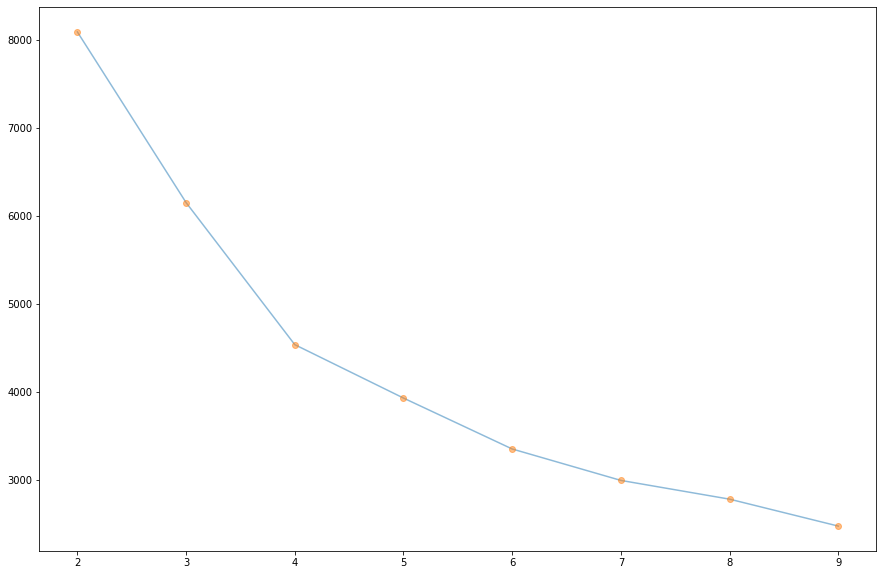

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.figure(figsize=(15,10))
distortions=[]
sil_scores=[]
for i in range(2,10):
    kmeans= KMeans(n_clusters=i, n_init=10, init= 'k-means++', algorithm='full', max_iter=300)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    label= kmeans.labels_
    sil_scores.append(silhouette_score(X, label))
plt.plot(np.arange(2,10,1), distortions, alpha=0.5)
plt.plot(np.arange(2,10,1), distortions,'o' ,alpha=0.5)
plt.show()

In [27]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300)
kmeans.fit(X)

KMeans(n_clusters=5)

In [28]:
kmeans.labels_

array([0, 1, 3, ..., 4, 1, 2], dtype=int32)

In [29]:
rfm['kmeans_cluster'] = kmeans.labels_

In [30]:
rfm[rfm['kmeans_cluster'] == 4].mean()

Recency            24.954424
Frequency          14.487936
Monetary          156.946777
kmeans_cluster      4.000000
dtype: float64

In [31]:
rfm.mean()

Recency               92.581199
Frequency             91.858188
Monetary          448183.228616
kmeans_cluster         1.576167
dtype: float64

In [32]:
kmeans.inertia_

3915.042067435744